In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from subgrid_parameterization.preprocess import SAM_helpers as sam
from subgrid_parameterization.preprocess.C14 import get_C14
from subgrid_parameterization.preprocess.mixing_length import get_mixing_length

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from sklearn.metrics import r2_score

In [3]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

# path = 'sam-bomex/'
# file = 'BOMEX_64x64x75_100m_40m_1s'
# file = 'BOMEX_3d'

path = "sam-rf01/"
file = "DYCOMS_RF01_96x96x320"
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = 'sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

In [4]:
ds = xr.open_dataset(path0 + path + file + ".nc")

In [5]:
ds

<xarray.Dataset> Size: 135MB
Dimensions:      (x: 1, y: 1, z: 320, time: 240)
Coordinates:
  * x            (x) float32 4B -122.0
  * y            (y) float32 4B 31.5
  * z            (z) float32 1kB 2.5 7.5 12.5 ... 1.588e+03 1.592e+03 1.598e+03
  * time         (time) datetime64[ns] 2kB 2001-07-10T06:01:00 ... 2001-07-10...
Data variables: (12/446)
    p            (z) float32 1kB ...
    PREC         (time) float32 960B ...
    CWP          (time) float32 960B ...
    IWP          (time) float32 960B ...
    RWP          (time) float32 960B ...
    SWP          (time) float32 960B ...
    ...           ...
    THLPRRP_IP   (time, z, y, x) float32 307kB ...
    RTPNRP_IP    (time, z, y, x) float32 307kB ...
    THLPNRP_IP   (time, z, y, x) float32 307kB ...
    RRPNRP_IP    (time, z, y, x) float32 307kB ...
    RRP3_IP      (time, z, y, x) float32 307kB ...
    NRP3_IP      (time, z, y, x) float32 307kB ...
Attributes:
    SAM version:  
    caseid:       96x96x320
    Conventions:  COARDS

In [6]:
# nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt
nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)

In [7]:
e = sam.get_TKE(ds)

# U2 = sam.stagger_var("U2", ds, zt)
# V2 = sam.stagger_var("V2", ds, zt)
# W2 = sam.stagger_var("W2", ds, zt)
# assert ( e == (0.5 * ( U2 + V2 + W2 ))).all()

In [8]:
disp = sam.get_disp(ds)

# U2DFSN = sam.stagger_var("U2DFSN", ds, zt)
# V2DFSN = sam.stagger_var("V2DFSN", ds, zt)
# assert ( disp == (0.5 * ( U2DFSN + V2DFSN ))).all()

In [9]:
C14 = get_C14(ds)
L, Lup, Ldown = get_mixing_length(ds)

# assert (C14 == (-3.0 / 2.0 * L / e**1.5 * disp) ).all()

Text(0.5, 0.98, 'Dissipation >= 0 due to ?, esp. during spinup')

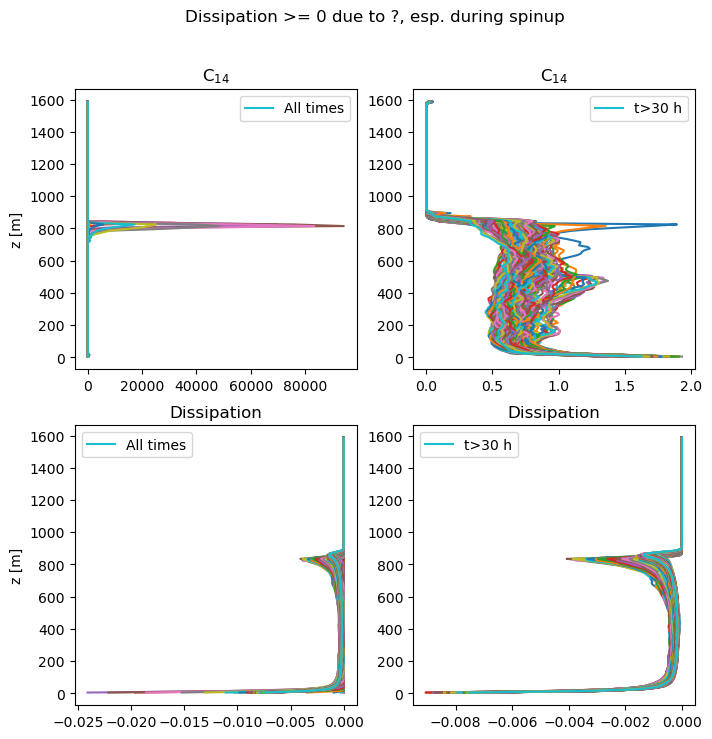

In [10]:
itime = range(30, ngrdcol)
kstart = 0
kend = nzm  # -21 #int(0.75*nzm)
try:
    del (fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
except:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(C14[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[0, 0].plot(C14[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
axs[0, 0].legend()
axs[0, 0].set_ylabel("z [m]")
axs[0, 0].set_title(r"C$_{14}$")
axs[0, 1].plot(C14[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[0, 1].plot(
    C14[itime[-1], kstart:kend].T, zt[itime[-1], kstart:kend].T, label="t>30 h"
)
axs[0, 1].legend()
axs[0, 1].set_title(r"C$_{14}$")
axs[1, 0].plot(disp[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[1, 0].plot(disp[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
#     U2DFSN[itime, kstart:kend].T, zt[itime, kstart:kend].T, "-"
# )  # ,label='U2DFSN')
# plt.plot(
#     V2DFSN[itime, kstart:kend].T, zt[itime, kstart:kend].T, "--"
# )  # label='V2DFSN')
axs[1, 0].legend()
axs[1, 0].set_ylabel("z [m]")
axs[1, 0].set_title("Dissipation")
axs[1, 1].plot(disp[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[1, 1].plot(
    disp[itime[-1], kstart:kend].T, zt[itime[-1], kstart:kend].T, label="t>30 h"
)
axs[1, 1].legend()
axs[1, 1].set_title("Dissipation")
fig.suptitle("Dissipation >= 0 due to ?, esp. during spinup")

Issue remains at model top. 
Solution is to exclude all points where dissipation is equal to zero, C14 is ill defined as well as excluding points where TKE = 0 which results in divsion by zero in both normalization of velocity variance input features, and in the labeling of C$_{14}$

deleted old figure


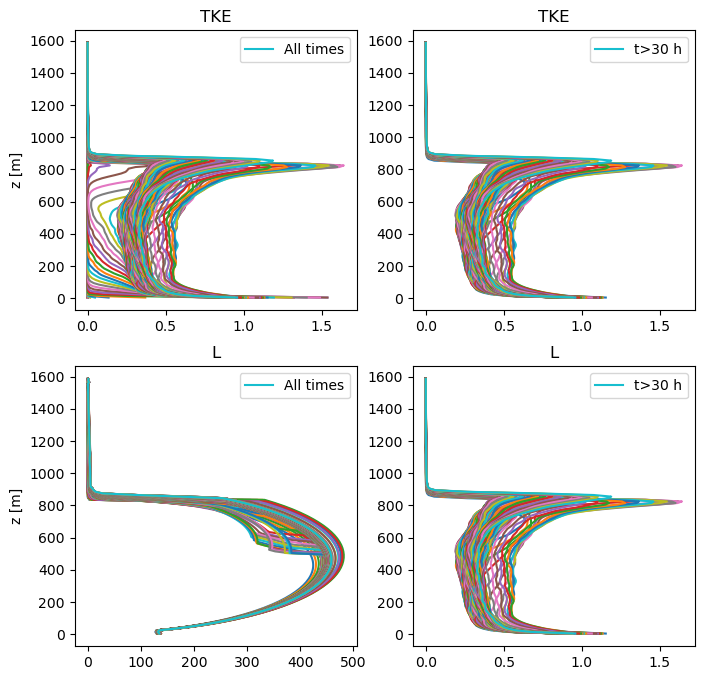

In [11]:
try:
    del (fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
except:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(e[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[0, 0].plot(e[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
axs[0, 0].legend()
axs[0, 0].set_ylabel("z [m]")
axs[0, 0].set_title("TKE")
axs[0, 1].plot(e[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[0, 1].plot(
    e[itime[-1], kstart:kend].T, zt[itime[-1], kstart:kend].T, label="t>30 h"
)
axs[0, 1].legend()
axs[0, 1].set_title("TKE")
axs[1, 0].plot(L[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[1, 0].plot(L[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
axs[1, 0].legend()
axs[1, 0].set_ylabel("z [m]")
axs[1, 0].set_title("L")
axs[1, 1].plot(e[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[1, 1].plot(
    e[itime[-1], kstart:kend].T, zt[itime[-1], kstart:kend].T, label="t>30 h"
)
axs[1, 1].legend()
axs[1, 1].set_title("L");

In [12]:
print(np.sum(disp < 0))
print(np.sum(disp == 0))
print(np.sum(disp > 0))

28886
9078
196


In [13]:
print(np.sum(C14 < 0))
print(np.sum(C14 == 0))
print(np.sum(C14 > 0))
print(np.sum(C14 > 2))

196
9078
28886
366


In [14]:
print(np.sum(e < 0))
print(np.sum(e == 0))
print(np.sum(e >= 0))

0
0
38160


In [15]:
C14max = 2
emin = (-1.5 * disp[disp < 0] * L[disp < 0] / C14max) ** (2 / 3)
print(np.sum(e[disp < 0] < emin))

366


Division by zero TKE is not the cause of large C14, rather a tolerance can be set from the maximum of C14 when clipping is used.

Text(0.5, 0, 'C$_{14}$')

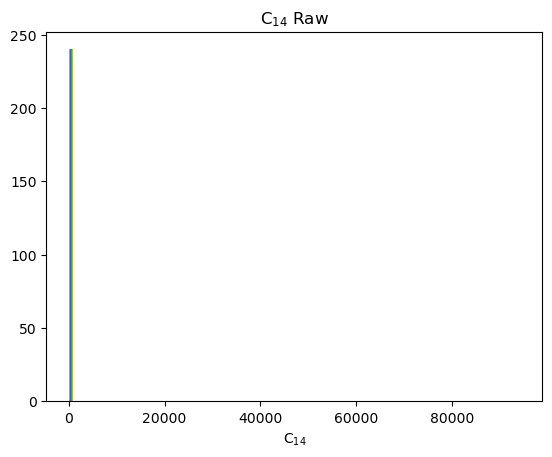

In [16]:
plt.hist(C14, bins=100)
plt.title(r"C$_{14}$ Raw")
plt.xlabel(r"C$_{14}$")
# plt.ylabel("Count")

Text(0, 0.5, 'Count')

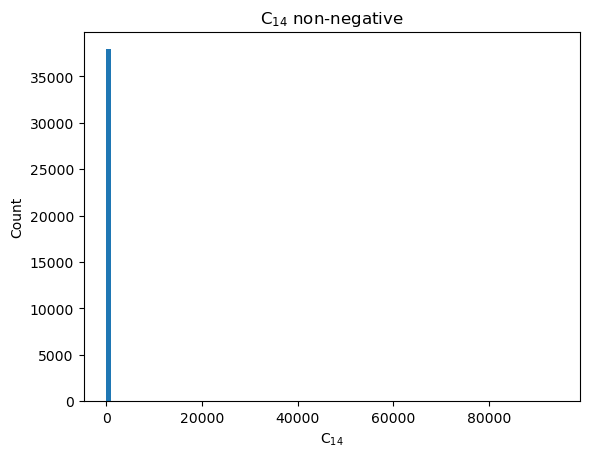

In [17]:
C14_nonNeg = C14[C14 >= 0]
plt.hist(C14_nonNeg, bins=100)
# plt.ylim((0, 2500))
plt.title(r"C$_{14}$ non-negative")
plt.xlabel(r"C$_{14}$")
plt.ylabel("Count")

Text(0.5, 0.98, 'C$_{14} positive$')

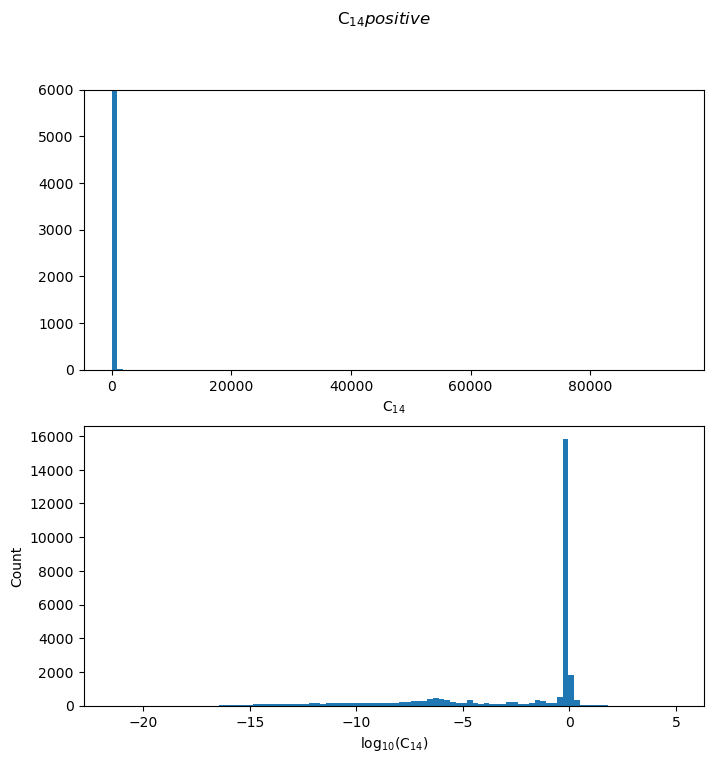

In [18]:
C14_pos = C14[C14 > 0]
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].hist(C14_pos, bins=100)
axs[0].set_ylim((0, 6000))
axs[0].set_xlabel(r"C$_{14}$")
axs[1].hist(np.log10(C14_pos), bins=100)
axs[1].set_xlabel(r"log$_{10}$(C$_{14}$)")
plt.ylabel("Count")
fig.suptitle(r"C$_{14} positive$")

In [19]:
print(np.mean(C14))
print(np.mean(C14_nonNeg))
print(np.mean(C14_pos))

25.263259870085367
25.401251012899817
33.38409933717817


In [20]:
C14_clip = C14_pos[e[disp < 0] > emin]

In [21]:
print(np.mean(C14_clip))

0.47508580144731655


Text(0, 0.5, 'Count')

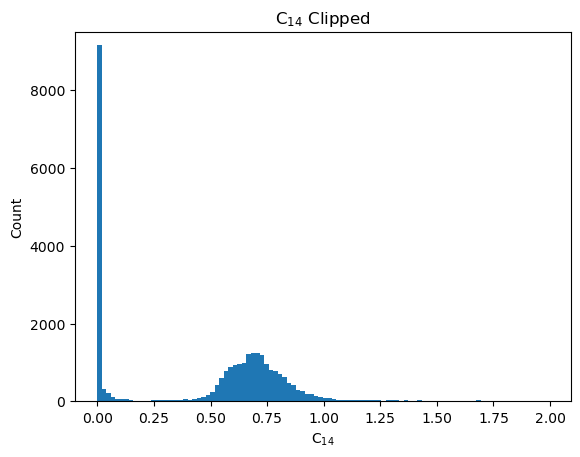

In [22]:
plt.hist(C14_clip, bins=100)
plt.ylim((0, 9500))
plt.title(r"C$_{14}$ Clipped")
plt.xlabel(r"C$_{14}$")
plt.ylabel("Count")

Setting the lower bound not to C$_{14}$>0 by dissipation < 0 , but by a dynamic tolerance on dissipation based on the minimum C$_{14} \neq$ 0 constructed similarly to the contraints on TKE based on the maximum C$_{14}$, could align above with ~0.2 minimum in CLUBB documentation tuning parameters table. 